In [ ]:
# Final Feature Engineering & Feature Store Prep
# Temporal Features 
# Spatial Features 
# Categorical Encoding
# Mocodes removed

In [38]:
import pandas as pd
from time import time

# Start with our fully cleaned DataFrame
df_final_features = df_cleaned.copy()

# --- Step A: Temporal Feature Engineering ---
print("Step A: Creating temporal features...")
df_final_features['date_occ_dt'] = pd.to_datetime(df_final_features['date occ'], errors='coerce')
df_final_features['time_occ_str'] = df_final_features['time occ'].astype(str).str.zfill(4)
df_final_features['occ_hour'] = pd.to_numeric(df_final_features['time_occ_str'].str[:2], errors='coerce')
df_final_features.dropna(subset=['date_occ_dt', 'occ_hour'], inplace=True)
df_final_features['occ_hour'] = df_final_features['occ_hour'].astype(int)
df_final_features['day_of_week'] = df_final_features['date_occ_dt'].dt.dayofweek
df_final_features['month'] = df_final_features['date_occ_dt'].dt.month
df_final_features['is_weekend'] = (df_final_features['day_of_week'] >= 5).astype(int)
def get_part_of_day(hour):
    if 5 <= hour < 12: return 'Morning'
    if 12 <= hour < 17: return 'Afternoon'
    if 17 <= hour < 21: return 'Evening'
    return 'Night'
df_final_features['part_of_day'] = df_final_features['occ_hour'].apply(get_part_of_day)

# --- Step B: Spatial Feature Engineering ---
print("\nStep B: Creating spatial features (bins)...")
if 'lat' in df_final_features.columns and 'lon' in df_final_features.columns:
    lat_bins, lon_bins = 20, 20
    df_final_features['lat_bin'] = pd.cut(df_final_features['lat'], bins=lat_bins, labels=False)
    df_final_features['lon_bin'] = pd.cut(df_final_features['lon'], bins=lon_bins, labels=False)
    df_final_features['spatial_bin'] = df_final_features.apply(
        lambda row: f"{row['lat_bin']}_{row['lon_bin']}" if pd.notnull(row['lat_bin']) and pd.notnull(row['lon_bin']) else None,
        axis=1
    ).astype('category')
    df_final_features.dropna(subset=['spatial_bin'], inplace=True)

# --- Step C: Categorical Feature Engineering ---
print("\nStep C: Creating categorical features (one-hot encoding)...")
categorical_features_to_encode = ['area name', 'vict sex', 'part_of_day', 'spatial_bin']
df_final_features = pd.get_dummies(df_final_features, columns=categorical_features_to_encode, drop_first=True, dtype=int)

# --- Step D: Final Cleanup and Column Selection ---
print("\nStep D: Cleaning up columns for final feature set...")
# ADDED 'mocodes' TO THIS LIST
columns_to_exclude = [
    'dr_no', 'date rptd', 'date occ', 'time occ', 'rpt dist no', 
    'crm cd', 'crm cd desc', 'vict descent', 'premis desc', 'status', 
    'status desc', 'crm cd 1', 'location', 'date_occ_dt', 'time_occ_str',
    'lat', 'lon', 'lat_bin', 'lon_bin', 'mocodes'
]
df_final_features.drop(columns=columns_to_exclude, inplace=True, errors='ignore')
df_final_features.columns = [c.replace(' ', '_') for c in df_final_features.columns]
print(f"Final feature count: {df_final_features.shape[1]}")

# --- Step E: Add Required Columns for Feature Store ---
print("\nStep E: Adding required columns for Feature Store...")
current_time_sec = int(round(time()))
df_final_features['event_time'] = pd.Series([current_time_sec]*len(df_final_features), dtype="float64")
# Match record IDs from original df to the now-filtered df_final_features
df_final_features['record_id'] = df_from_athena.loc[df_final_features.index]['dr_no'].astype(str)
print("Required columns 'event_time' and 'record_id' have been added.")

# --- Display the final, ready-to-ingest DataFrame ---
print("\nSample of the final DataFrame to be ingested into the Feature Store:")
display(df_final_features.head())

Step A: Creating temporal features...

Step B: Creating spatial features (bins)...

Step C: Creating categorical features (one-hot encoding)...

Step D: Cleaning up columns for final feature set...
Final feature count: 90

Step E: Adding required columns for Feature Store...
Required columns 'event_time' and 'record_id' have been added.

Sample of the final DataFrame to be ingested into the Feature Store:


/tmp/ipykernel_432/558383133.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final_features['date_occ_dt'] = pd.to_datetime(df_final_features['date occ'], errors='coerce')


,area,part_1-2,vict_age,premis_cd,time_hour,day_of_week,month,occ_hour,is_weekend,area_name_Central,...,vict_sex_X,part_of_day_Evening,part_of_day_Morning,part_of_day_Night,spatial_bin_0_15,spatial_bin_0_19,spatial_bin_19_0,spatial_bin_6_0,event_time,record_id
0,7,1,0.0,101.0,21,6,3,21,1,0,...,0,0,0,1,0,0,0,0,1.750721e+09,190326475
1,1,1,47.0,128.0,18,5,2,18,1,1,...,0,1,0,0,0,0,0,0,1.750721e+09,200106753
2,3,1,19.0,502.0,17,2,11,17,0,0,...,1,1,0,0,0,0,0,0,1.750721e+09,200320258
3,9,1,19.0,405.0,20,1,3,20,0,0,...,0,1,0,0,0,0,0,0,1.750721e+09,200907217
4,4,1,0.0,101.0,6,2,9,6,0,0,...,0,0,1,0,0,0,0,0,1.750721e+09,200412582


In [39]:
!pip install statsmodels --quiet

/tmp/ipykernel_432/4163820676.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_analysis['date_occ_dt'] = pd.to_datetime(df_analysis['date occ'], errors='coerce')


--- Generating Temporal Heatmaps ---


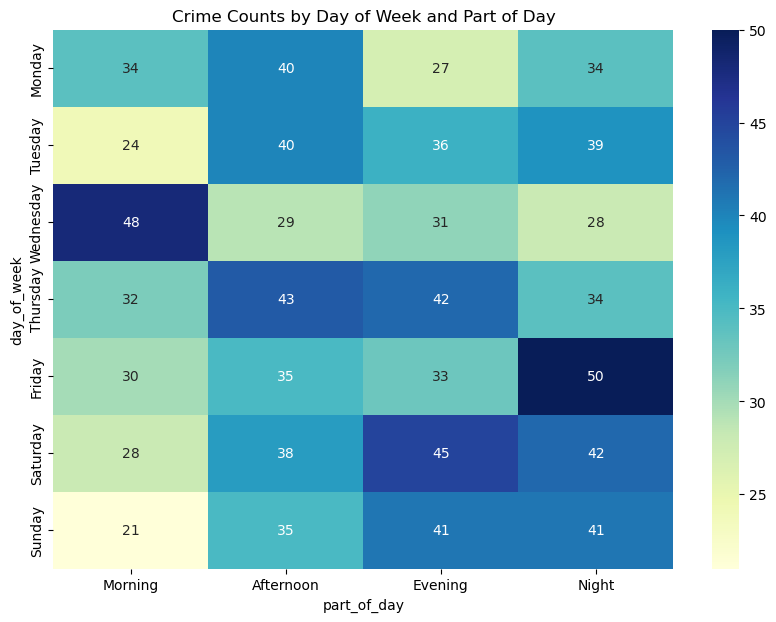

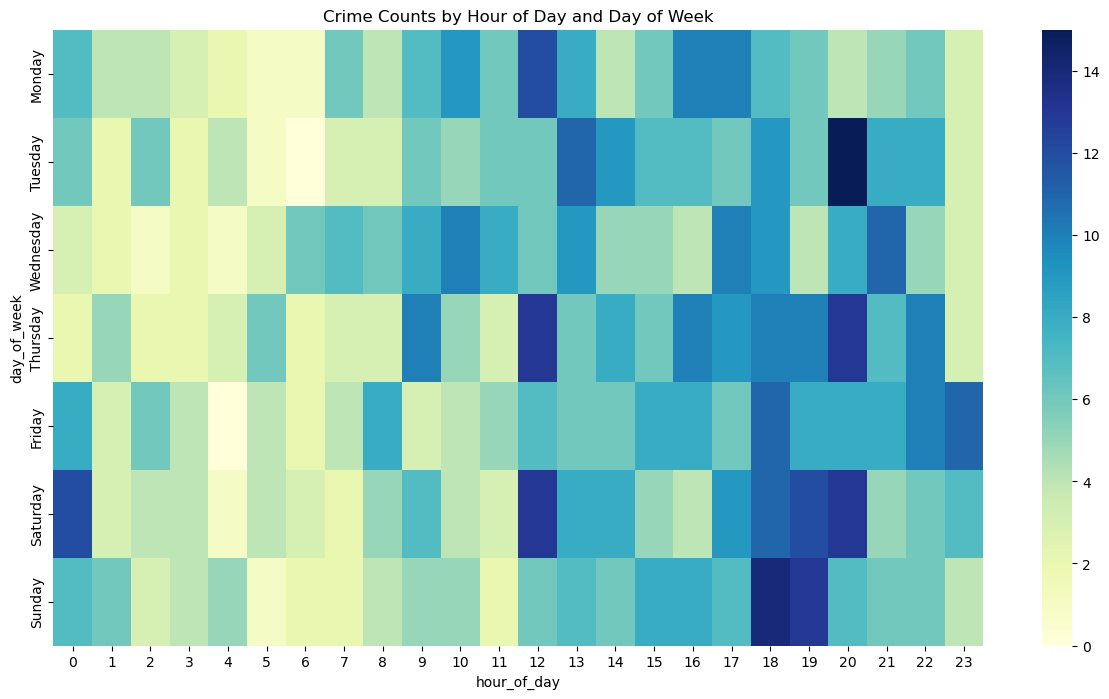


--- Generating Seasonal and Long-Term Trend Plots ---


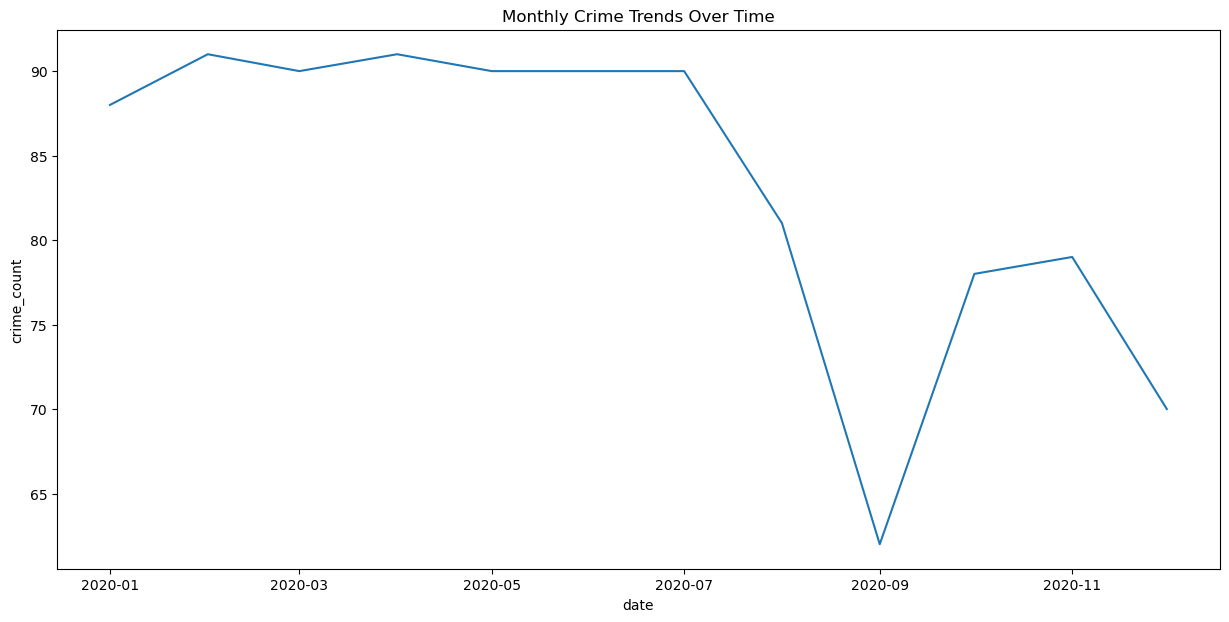

Skipping seasonal decomposition: Not enough monthly data points for a yearly cycle.


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Use the cleaned DataFrame from the previous steps
df_analysis = df_cleaned.copy()

# --- Temporal Feature Engineering for EDA ---
# We create these features here specifically for the plots below.
df_analysis['date_occ_dt'] = pd.to_datetime(df_analysis['date occ'], errors='coerce')
df_analysis['time_occ_str'] = df_analysis['time occ'].astype(str).str.zfill(4)
df_analysis['hour_of_day'] = pd.to_numeric(df_analysis['time_occ_str'].str[:2], errors='coerce')
df_analysis['day_of_week'] = df_analysis['date_occ_dt'].dt.day_name()
df_analysis['month'] = df_analysis['date_occ_dt'].dt.month
df_analysis['year'] = df_analysis['date_occ_dt'].dt.year

def get_part_of_day(hour):
    if 5 <= hour < 12: return 'Morning'
    if 12 <= hour < 17: return 'Afternoon'
    if 17 <= hour < 21: return 'Evening'
    return 'Night'
df_analysis['part_of_day'] = df_analysis['hour_of_day'].apply(get_part_of_day)

# --- Temporal Trend Analysis (Heatmaps) ---
print("--- Generating Temporal Heatmaps ---")
try:
    # Heatmap 1: Day of Week vs. Part of Day
    crime_counts_temporal = pd.crosstab(df_analysis['day_of_week'], df_analysis['part_of_day'])
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    part_day_order = ['Morning', 'Afternoon', 'Evening', 'Night']
    crime_counts_temporal = crime_counts_temporal.reindex(index=day_order, columns=part_day_order)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(crime_counts_temporal, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Crime Counts by Day of Week and Part of Day')
    plt.show()

    # Heatmap 2: Day of Week vs. Hour
    crime_counts_hourly = pd.crosstab(df_analysis['day_of_week'], df_analysis['hour_of_day'])
    crime_counts_hourly = crime_counts_hourly.reindex(index=day_order)

    plt.figure(figsize=(15, 8))
    sns.heatmap(crime_counts_hourly, cmap='YlGnBu')
    plt.title('Crime Counts by Hour of Day and Day of Week')
    plt.show()
except Exception as e:
    print(f"An error occurred during heatmap generation: {e}")

# --- Seasonal and Long-Term Trend Analysis ---
print("\n--- Generating Seasonal and Long-Term Trend Plots ---")
try:
    # Monthly trend plot
    crime_counts_monthly = df_analysis.groupby(['year', 'month']).size().reset_index(name='crime_count')
    crime_counts_monthly['date'] = pd.to_datetime(crime_counts_monthly['year'].astype(str) + '-' + crime_counts_monthly['month'].astype(str))
    
    plt.figure(figsize=(15, 7))
    sns.lineplot(x='date', y='crime_count', data=crime_counts_monthly)
    plt.title('Monthly Crime Trends Over Time')
    plt.show()

    # Seasonal Decomposition
    time_series = crime_counts_monthly.set_index('date')['crime_count']
    # Ensure at least two full periods of data for decomposition
    if len(time_series) >= 24:
        decomposition = seasonal_decompose(time_series, model='additive', period=12)
        fig = decomposition.plot()
        fig.set_size_inches(12, 8)
        plt.suptitle('Seasonal Decomposition of Monthly Crime Trends', y=1.02)
        plt.show()
    else:
        print("Skipping seasonal decomposition: Not enough monthly data points for a yearly cycle.")

except Exception as e:
    print(f"An error occurred during trend analysis: {e}")